# Feature Engineering and Modeling

In [1]:
import arff

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import fastai.tabular.all as fai

## Load data

In [2]:
freq_data = arff.load('data/freMTPL2freq.arff')
freq_df = pd.DataFrame(
    freq_data, 
    columns=[
        "IDpol", 
        "ClaimNb", 
        "Exposure", 
        "Area", 
        "VehPower",
        "VehAge",
        "DrivAge", 
        "BonusMalus", 
        "VehBrand", 
        "VehGas", 
        "Density", 
        "Region"
    ]
)

In [3]:
freq_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,5.0,1.0,0.75000,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,10.0,1.0,0.09000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,11.0,1.0,0.84000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93'
678009,6114327.0,0.0,0.00274,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11'
678010,6114328.0,0.0,0.00274,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82'
678011,6114329.0,0.0,0.00274,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26'


In [4]:
sev_data = arff.load('data/freMTPL2sev.arff')
sev_df = pd.DataFrame(sev_data, columns=["IDpol", "ClaimAmount"])

In [5]:
sev_df

,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00
...,...,...
26634,3254353.0,1200.00
26635,3254353.0,1800.00
26636,3254353.0,1000.00
26637,2222064.0,767.55


## Feature engineering

Some points should be mentioned here about the plan.
1. There are a lot of samples in the dataset that do not have non-zero claims amounts. 
    1. I think this would disturb the model to replace the dependent variable for these samples with zero.
    1. As was found in the exploratory analysis, it seems like the distribution of the two populations are almost identical.
    1. The rest of the work will exclude the null ClaimAmount samples.
1. There are some issues with the dependent variable that should be dealt with.
    1. The span is over many orders of magnitude and it is not distributed evenly so it was decided to work with the log.
    1. Some outliers will simply be thrown out.
    1. There are 2 strange peaks in the distribution that may call for being dealt with.
1. The correlation of the features to the target are very weak.
    1. I think this calls for a more flexible model.
    1. I'll even try some flexible feature engineering on the categorical variables that will also serve the purpose of trying out another model.

### One-hot encoding of the categorical data

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [7]:
cont_vars, cat_vars = fai.cont_cat_split(freq_df)

In [8]:
enc = OneHotEncoder()
enc.fit(freq_df[cat_vars])
enc.categories_

[array(["'A'", "'B'", "'C'", "'D'", "'E'", "'F'"], dtype=object),
 array(["'B1'", "'B10'", "'B11'", "'B12'", "'B13'", "'B14'", "'B2'",
        "'B3'", "'B4'", "'B5'", "'B6'"], dtype=object),
 array(['Diesel', 'Regular'], dtype=object),
 array(["'R11'", "'R21'", "'R22'", "'R23'", "'R24'", "'R25'", "'R26'",
        "'R31'", "'R41'", "'R42'", "'R43'", "'R52'", "'R53'", "'R54'",
        "'R72'", "'R73'", "'R74'", "'R82'", "'R83'", "'R91'", "'R93'",
        "'R94'"], dtype=object)]

In [9]:
cat_enc_df = pd.DataFrame(
    enc.transform(freq_df[cat_vars]).toarray(), 
    columns=enc.get_feature_names_out(cat_vars), 
)
cat_enc_df

,Area_'A',Area_'B',Area_'C',Area_'D',Area_'E',Area_'F',VehBrand_'B1',VehBrand_'B10',VehBrand_'B11',VehBrand_'B12',...,Region_'R53',Region_'R54',Region_'R72',Region_'R73',Region_'R74',Region_'R82',Region_'R83',Region_'R91',Region_'R93',Region_'R94'
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
678009,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
678010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
678011,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
claim_df = pd.concat([freq_df[cont_vars], cat_enc_df], axis=1)
claim_df = pd.merge(claim_df, sev_df, how='left', on='IDpol')
claim_df

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_'A',Area_'B',...,Region_'R54',Region_'R72',Region_'R73',Region_'R74',Region_'R82',Region_'R83',Region_'R91',Region_'R93',Region_'R94',ClaimAmount
0,1.0,1.0,0.10000,5.0,0.0,55.0,50.0,1217.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,3.0,1.0,0.77000,5.0,0.0,55.0,50.0,1217.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
2,5.0,1.0,0.75000,6.0,2.0,52.0,50.0,54.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,10.0,1.0,0.09000,7.0,0.0,46.0,50.0,76.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,11.0,1.0,0.84000,7.0,0.0,46.0,50.0,76.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679508,6114326.0,0.0,0.00274,4.0,0.0,54.0,50.0,3317.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
679509,6114327.0,0.0,0.00274,4.0,0.0,41.0,95.0,9850.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
679510,6114328.0,0.0,0.00274,6.0,2.0,45.0,50.0,1323.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
679511,6114329.0,0.0,0.00274,4.0,0.0,60.0,50.0,95.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Rmove null ClaimAmount samples and converto to log
For experimentation purposes, make a version of the data with the one-hot encoding of categorical values and another without. This is being done because the intent below is to try an XGBoost regressor which can also handle categorical variables.

In [11]:
null_claim = claim_df['ClaimAmount'].isna()

In [12]:
def log_col(df, col):
    """
    Convert a column of a dataframe to its log.
    """
    out_df = df.copy()
    out_df = out_df.rename({col: f"log{col}"}, axis=1)
    out_df.loc[~out_df[f"log{col}"].isna(), f"log{col}"] = (
        np.log(out_df.loc[~out_df[f"log{col}"].isna(), f"log{col}"])
    )
    return out_df

In [13]:
log_claim_df = log_col(claim_df, 'ClaimAmount')
log_claim_df[~null_claim]

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_'A',Area_'B',...,Region_'R54',Region_'R72',Region_'R73',Region_'R74',Region_'R82',Region_'R83',Region_'R91',Region_'R93',Region_'R94',logClaimAmount
66,139.0,1.0,0.75,7.0,1.0,61.0,50.0,27000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.713733
93,190.0,1.0,0.14,12.0,5.0,50.0,60.0,56.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.591781
199,414.0,1.0,0.14,4.0,0.0,36.0,85.0,4792.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.283826
205,424.0,2.0,0.62,10.0,0.0,51.0,100.0,27000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.897341
206,424.0,2.0,0.62,10.0,0.0,51.0,100.0,27000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.194654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678974,6113793.0,1.0,0.14,7.0,2.0,51.0,50.0,178.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.478667
678998,6113817.0,1.0,0.17,4.0,0.0,35.0,51.0,1719.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.161063
679015,6113834.0,2.0,0.17,15.0,3.0,36.0,50.0,181.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.238928
679016,6113834.0,2.0,0.17,15.0,3.0,36.0,50.0,181.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.570649


In [14]:
claim_cont_cat_df = pd.merge(freq_df, sev_df, how='left', on='IDpol') 
log_claim_cont_cat_df = log_col(claim_cont_cat_df, 'ClaimAmount')
log_claim_cont_cat_df.loc[:, cat_vars] = (
    log_claim_cont_cat_df[cat_vars].astype('category')
)
log_claim_cont_cat_nonull_df = log_claim_cont_cat_df.loc[~null_claim, :]
log_claim_cont_cat_nonull_df.loc[:, cat_vars] = (
    log_claim_cont_cat_nonull_df[cat_vars].astype('category')
)
log_claim_cont_cat_nonull_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,logClaimAmount
66,139.0,1.0,0.75,'F',7.0,1.0,61.0,50.0,'B12',Regular,27000.0,'R11',5.713733
93,190.0,1.0,0.14,'B',12.0,5.0,50.0,60.0,'B12',Diesel,56.0,'R25',7.591781
199,414.0,1.0,0.14,'E',4.0,0.0,36.0,85.0,'B12',Regular,4792.0,'R11',7.283826
205,424.0,2.0,0.62,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',6.897341
206,424.0,2.0,0.62,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',9.194654
...,...,...,...,...,...,...,...,...,...,...,...,...,...
678974,6113793.0,1.0,0.14,'C',7.0,2.0,51.0,50.0,'B12',Diesel,178.0,'R72',7.478667
678998,6113817.0,1.0,0.17,'D',4.0,0.0,35.0,51.0,'B12',Regular,1719.0,'R82',7.161063
679015,6113834.0,2.0,0.17,'C',15.0,3.0,36.0,50.0,'B12',Regular,181.0,'R54',9.238928
679016,6113834.0,2.0,0.17,'C',15.0,3.0,36.0,50.0,'B12',Regular,181.0,'R54',7.570649


## Experiment with some modeling
At this point I think it makes sense to experiment with some modeling to help decide how to proceed. As was mentioned before, I think something rather flexible would help a lot so as to decrease the load on the manual feature engineering. This was motivated by the poor correlation between all of the features and the target variable. I chose to go with XGBoost for investigation. In the meantime, I quickly tried a linear regression and a K-nearest-neighbor model with no improvement.

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, KFold

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

### Prepare fitting inputs

Here the outliers mentioned before are being thrown out.

In [16]:
log_claim_low_thresh = 0
log_claim_high_thresh = 13

In [17]:
sample_select = (
    (
        log_claim_cont_cat_nonull_df['logClaimAmount'] 
        > log_claim_low_thresh
    )
    & (
        log_claim_cont_cat_nonull_df['logClaimAmount'] 
        <= log_claim_high_thresh
    )
)

Two versions of the dataset, with categorical and with one-hot encoding, will be played with hear with switches to go back and forth between them.

In [18]:
scaler = MinMaxScaler()
features_cont_cat_nonull_df = (
    log_claim_cont_cat_nonull_df
        .loc[sample_select, :]
        .set_index('IDpol')
        .drop('logClaimAmount', axis=1)
)
features_cont_cat_nonull_df[cat_vars] = (
    features_cont_cat_nonull_df[cat_vars]
        .astype('category')
)
features_cont_nonull = (
    scaler.fit_transform(
        features_cont_cat_nonull_df[[
            var for var in cont_vars if var != 'IDpol'
        ]]
    )
)
features_cont_cat_nonull_df.loc[:, [
    var for var in cont_vars if var != 'IDpol'
]] = features_cont_nonull
features_cont_cat_nonull_df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
IDpol,,,,,,,,,,,
139.0,0.000000,0.374143,'F',0.272727,0.010101,0.530864,0.000000,'B12',Regular,1.000000,'R11'
190.0,0.000000,0.068724,'B',0.727273,0.050505,0.395062,0.056180,'B12',Diesel,0.002000,'R25'
414.0,0.000000,0.068724,'E',0.000000,0.000000,0.222222,0.196629,'B12',Regular,0.177421,'R11'
424.0,0.066667,0.309053,'F',0.545455,0.000000,0.407407,0.280899,'B12',Regular,1.000000,'R11'
424.0,0.066667,0.309053,'F',0.545455,0.000000,0.407407,0.280899,'B12',Regular,1.000000,'R11'
...,...,...,...,...,...,...,...,...,...,...,...
6113793.0,0.000000,0.068724,'C',0.272727,0.020202,0.407407,0.000000,'B12',Diesel,0.006519,'R72'
6113817.0,0.000000,0.083745,'D',0.000000,0.000000,0.209877,0.005618,'B12',Regular,0.063597,'R82'
6113834.0,0.066667,0.083745,'C',1.000000,0.030303,0.222222,0.000000,'B12',Regular,0.006630,'R54'


In [19]:
scaler = MinMaxScaler()
log_claim_nonull_df = log_claim_df.loc[~null_claim, :]
features_nonull_df = (
    log_claim_nonull_df
        .loc[sample_select, :]
        .set_index('IDpol')
        .drop('logClaimAmount', axis=1)
)
features_nonull = scaler.fit_transform(features_nonull_df)
features_nonull_df = pd.DataFrame(
    features_nonull, 
    columns=features_nonull_df.columns, 
    index=features_nonull_df.index, 
)
features_nonull_df

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_'A',Area_'B',Area_'C',...,Region_'R53',Region_'R54',Region_'R72',Region_'R73',Region_'R74',Region_'R82',Region_'R83',Region_'R91',Region_'R93',Region_'R94'
IDpol,,,,,,,,,,,,,,,,,,,,,
139.0,0.000000,0.374143,0.272727,0.010101,0.530864,0.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190.0,0.000000,0.068724,0.727273,0.050505,0.395062,0.056180,0.002000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414.0,0.000000,0.068724,0.000000,0.000000,0.222222,0.196629,0.177421,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424.0,0.066667,0.309053,0.545455,0.000000,0.407407,0.280899,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424.0,0.066667,0.309053,0.545455,0.000000,0.407407,0.280899,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6113793.0,0.000000,0.068724,0.272727,0.020202,0.407407,0.000000,0.006519,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6113817.0,0.000000,0.083745,0.000000,0.000000,0.209877,0.005618,0.063597,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6113834.0,0.066667,0.083745,1.000000,0.030303,0.222222,0.000000,0.006630,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Prepare dependent variable
log_claim_amount_nonull_df = (
    log_claim_cont_cat_nonull_df[['IDpol', 'logClaimAmount']]
        .loc[
            sample_select, 
            :, 
        ]
        .set_index('IDpol')
)
log_claim_amount_nonull_df

,logClaimAmount
IDpol,
139.0,5.713733
190.0,7.591781
414.0,7.283826
424.0,6.897341
424.0,9.194654
...,...
6113793.0,7.478667
6113817.0,7.161063
6113834.0,9.238928


### Setup model

In [21]:
WITH_CATEGORICAL = 1
XGBOOST = 1

In [22]:
X_df = (
    features_cont_cat_nonull_df if WITH_CATEGORICAL
    else features_nonull_df
)
y_df = log_claim_amount_nonull_df

I suspect that there will be a lot of outliers to protect against so I decided to choose an absolute error objective. The parameters used for XGBoost here have been played with by hand.

In [23]:
objective = 'reg:absoluteerror'
eval_metric = 'rmse'
enable_categorical = True if WITH_CATEGORICAL else False

In [24]:
model = XGBRegressor(
    n_estimators=100, 
    eta=0.3, # 0.3
    gamma=1, # 0
    max_depth=6, # 6
    max_leaves=10, 
    min_child_weight=20, # 1
    subsample=0.5, # 1
    reg_lambda=10, # 1 (L2)
    reg_alpha=2, # 0 (L1)
    grow_policy='depthwise', # depthwise
    tree_method='hist', # auto
    max_bin=16, # 256
    random_state=0, 
    enable_categorical=enable_categorical, 
    objective=objective, 
    eval_metric=eval_metric, 
) if XGBOOST else KNeighborsRegressor() # LinearRegression()

### Cross-validation

In [25]:
cv_iterator = KFold(
    n_splits=10, 
    shuffle=True, 
    random_state=0, 
)

In [26]:
cv_results = cross_validate(
    model, 
    X_df, 
    y_df, 
    scoring=[
        'neg_root_mean_squared_error', 
        'neg_median_absolute_error', 
    ], 
    cv=cv_iterator, 
    return_estimator=True, 
)

In [27]:
print(
    "Average test_neg_root_mean_squared_error"
    f" = {cv_results['test_neg_root_mean_squared_error'].mean()}"
)
print(
    "Average test_neg_median_absolute_error"
    f" = {cv_results['test_neg_median_absolute_error'].mean()}"
)

Average test_neg_root_mean_squared_error = -1.140613737534728
Average test_neg_median_absolute_error = -0.22305543652250903


### Plot results

In [28]:
def plot_regression(
        X_df, 
        y_df, 
        fold, 
        i_data, 
        cv_results,
        ax,  
        sort_by_pred=True, 
        col=None, 
        **kwargs, 
    ):
    X_data_df = X_df.iloc[i_data]
    y_pred_df = pd.DataFrame(
        cv_results['estimator'][fold]
            .predict(X_data_df)
            .flatten(), 
        columns=['prediction'], 
        index=X_data_df.index
    )
    y_data_df = y_df.iloc[i_data]
    y_fold_df = pd.concat([y_data_df, y_pred_df], axis=1)
    X_y_fold_df = pd.concat([X_data_df, y_fold_df], axis=1)
    sort_col = 'prediction' if sort_by_pred else 'logClaimAmount'
    if col is None:
        y_fold_df = y_fold_df.sort_values(sort_col)
        ax.plot(
            y_fold_df['logClaimAmount'].to_numpy(), 
            marker='.',
            linestyle='', 
            label='logClaimAmount', 
        )
        ax.plot(y_fold_df['prediction'].to_numpy(), label='prediction')
    else:
        X_y_fold_df = X_y_fold_df.sort_values(col)
        ax.plot(
            X_y_fold_df[col].to_numpy(), 
            X_y_fold_df['logClaimAmount'].to_numpy(), 
            marker='.',
            linestyle='', 
            label='logClaimAmount', 
        )
        ax.plot(
            X_y_fold_df[col].to_numpy(), 
            X_y_fold_df['prediction'].to_numpy(), 
            label='prediction'
        )
        ax.set_xlabel(col)
    ax.legend()
    _ = ax.set(**kwargs)

I chose two ways of visualizing the fits. The first is to simple order the sample in increasing prediction and plot the targets surrounding them. The second is to plot the dependent variable as a function of each of the independent variables (further below).

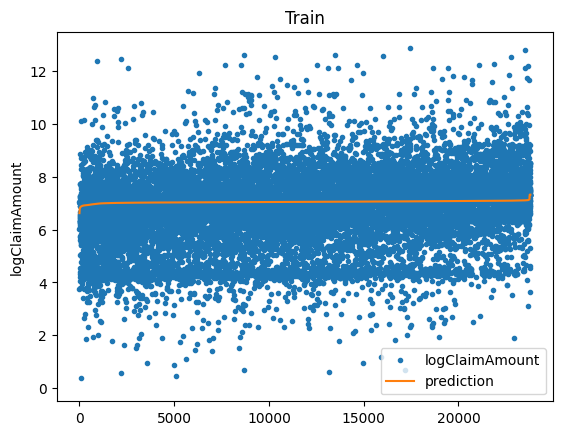

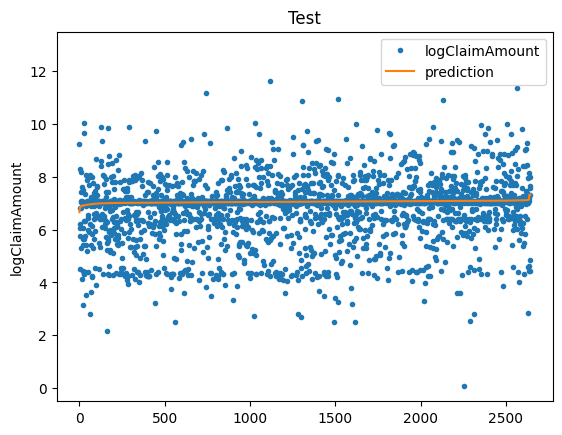

In [29]:
fold = 0
ylim = [-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5]
sort_by_pred = True
for fold_i, (train_i, test_i) in enumerate(
    cv_iterator.split(X_df, y_df)
):
    if fold_i==fold:
        fig_train, ax_train = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            train_i, 
            cv_results, 
            ax_train, 
            sort_by_pred=sort_by_pred, 
            ylabel='logClaimAmount', 
            ylim=ylim, 
            title='Train', 
        )
        fig_test, ax_test = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            test_i, 
            cv_results, 
            ax_test, 
            sort_by_pred=sort_by_pred, 
            ylabel='logClaimAmount', 
            ylim=ylim, 
            title='Test', 
        )        

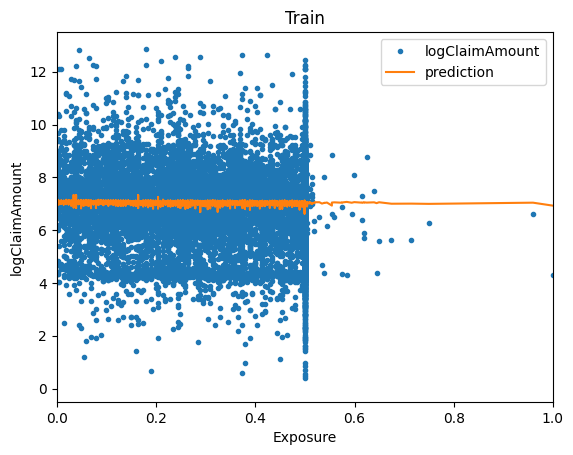

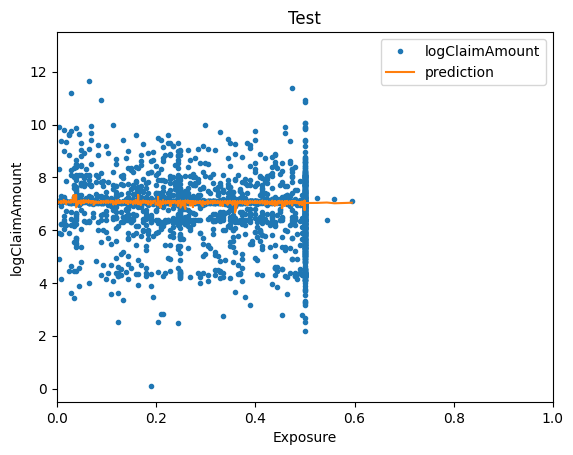

In [30]:
fold = 0
ylim = [-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5]
xlim = [0, 1]
sort_by_pred = True
col = "Exposure"
for fold_i, (train_i, test_i) in enumerate(
    cv_iterator.split(X_df, y_df)
):
    if fold_i==fold:
        fig_train, ax_train = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            train_i, 
            cv_results, 
            ax_train, 
            sort_by_pred=sort_by_pred, 
            col=col, 
            ylabel='logClaimAmount', 
            ylim=ylim, 
            xlim=xlim, 
            title='Train', 
        )
        fig_test, ax_test = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            test_i, 
            cv_results, 
            ax_test, 
            sort_by_pred=sort_by_pred, 
            col=col, 
            ylabel='logClaimAmount', 
            xlim=xlim, 
            ylim=ylim, 
            title='Test', 
        )        

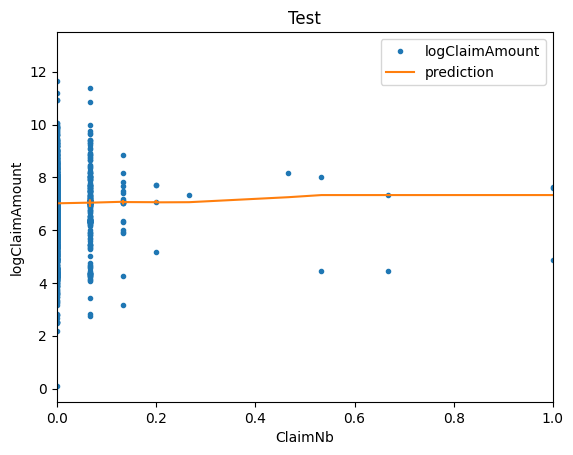

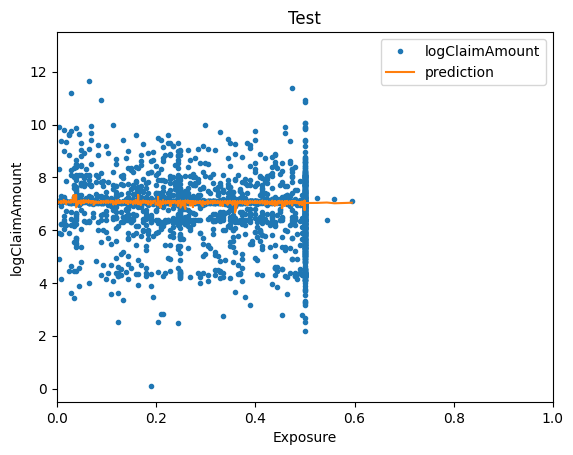

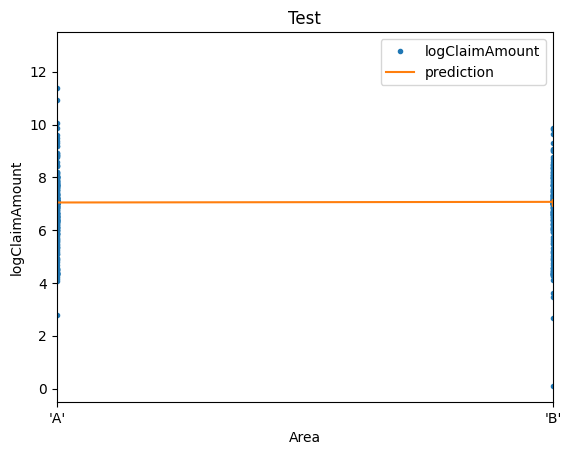

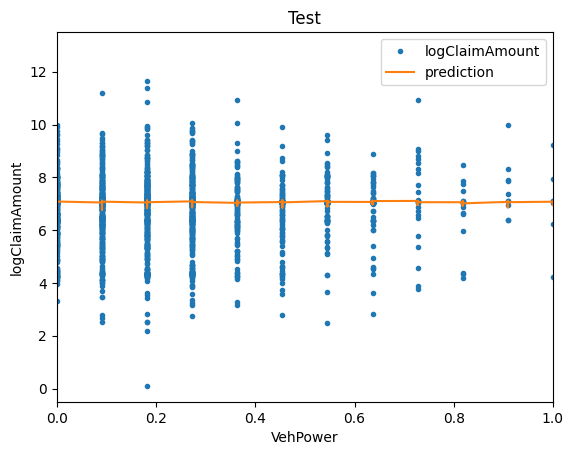

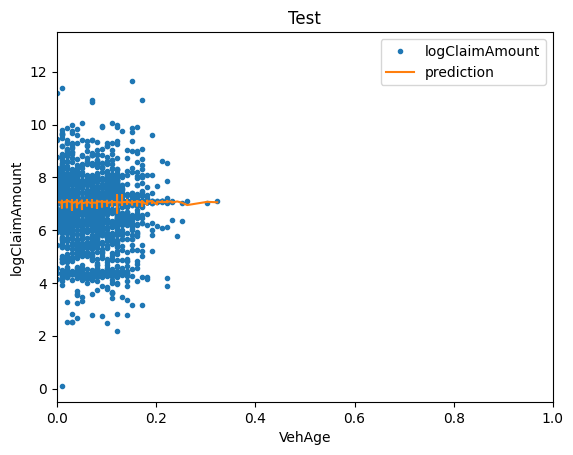

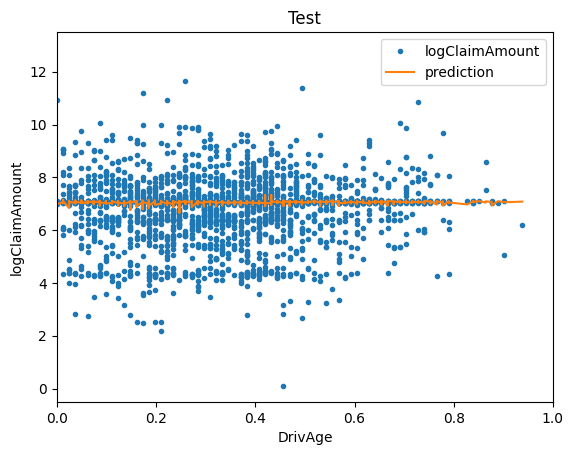

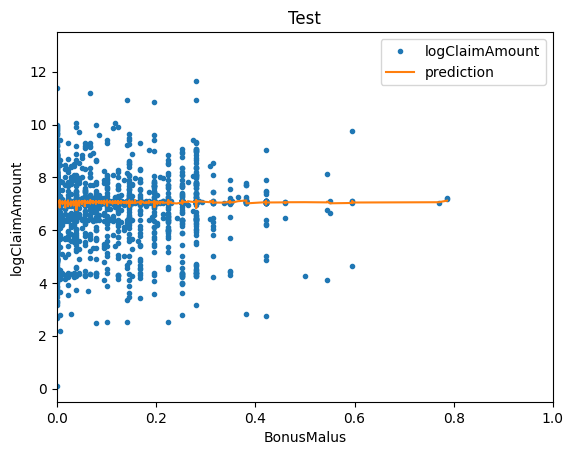

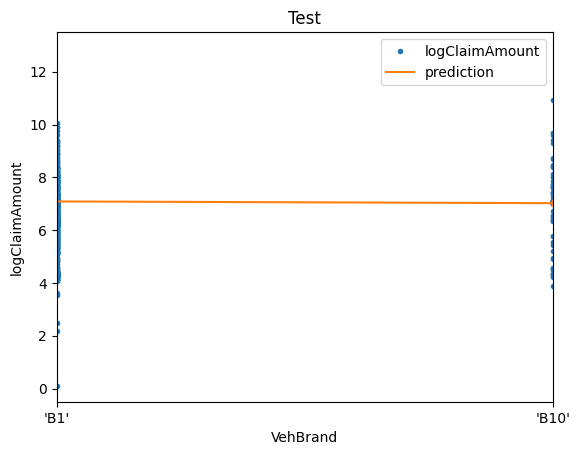

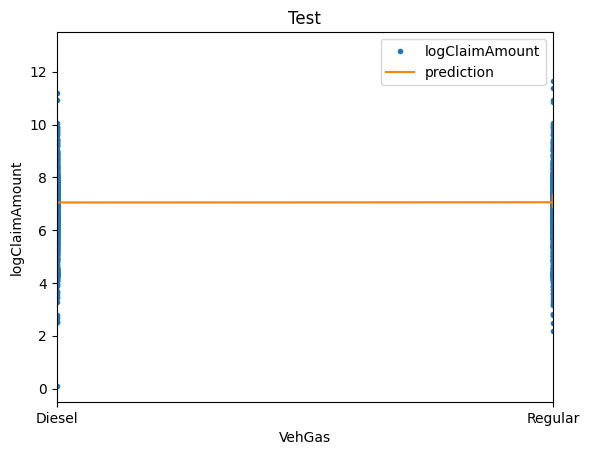

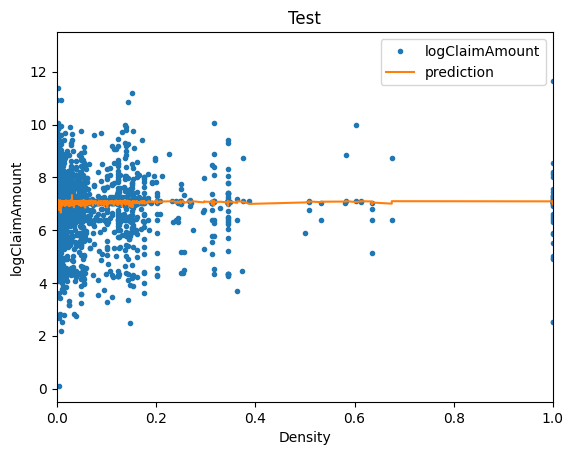

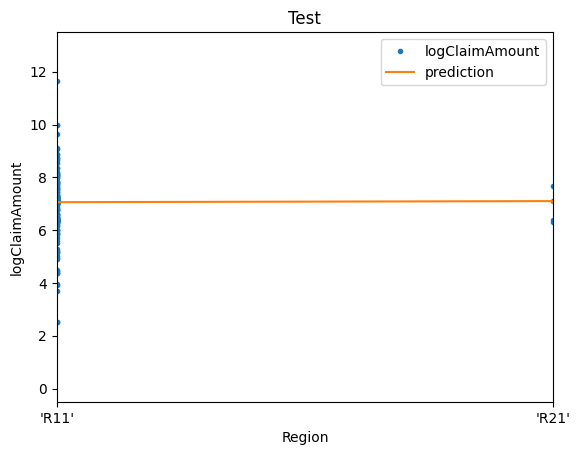

In [31]:
# Plot dependencies over all variables one-by-one
if 1:
    fold = 0
    ylim = [-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5]
    xlim = [0, 1]
    sort_by_pred = True
    for col in X_df.columns:
        for fold_i, (train_i, test_i) in enumerate(
            cv_iterator.split(X_df, y_df)
        ):
            if fold_i==fold:
                fig_test, ax_test = plt.subplots()
                plot_regression(
                    X_df, 
                    y_df, 
                    fold_i, 
                    test_i, 
                    cv_results, 
                    ax_test, 
                    sort_by_pred=sort_by_pred, 
                    col=col, 
                    ylabel='logClaimAmount', 
                    xlim=xlim, 
                    ylim=ylim, 
                    title='Test', 
                )        

From the plots above, it is clear that the peak in the logClaimAmount distribution is seriously dominating the fit. Especially since the other samples seem to be scattered so nicely around it in many of the dimensions. This is not so great for the pricing model because it pretty much will assign everyone a very similar price.

## fast.ai model and latent embedding of categorical variables
As I'm having some troubles having the model express the intricacies of the data well, I tried to see if we can generate some embedding for the categorical variables as well as try out another model.

### Preprocess

Here I'll try to remove the bands where the logClaimAmount peaks near 4.4 and 7. This is in hopes that the fit and the subsequent embeddings are not so dominated by those bands and more by the spread.

In [32]:
# Make middle thresholds equal to erase their effect
REMOVE_BANDS = 1
log_claim_low_thresh = 0
log_claim_med1_thresh = 4.1 if REMOVE_BANDS else 4.4
log_claim_med2_thresh = 4.7 if REMOVE_BANDS else 4.4
log_claim_med3_thresh = 6.9 if REMOVE_BANDS else 7
log_claim_med4_thresh = 7.1 if REMOVE_BANDS else 7
log_claim_high_thresh = 13

In [33]:
X_y_df = pd.concat([X_df, y_df], axis=1)
X_y_df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,logClaimAmount
IDpol,,,,,,,,,,,,
139.0,0.000000,0.374143,'F',0.272727,0.010101,0.530864,0.000000,'B12',Regular,1.000000,'R11',5.713733
190.0,0.000000,0.068724,'B',0.727273,0.050505,0.395062,0.056180,'B12',Diesel,0.002000,'R25',7.591781
414.0,0.000000,0.068724,'E',0.000000,0.000000,0.222222,0.196629,'B12',Regular,0.177421,'R11',7.283826
424.0,0.066667,0.309053,'F',0.545455,0.000000,0.407407,0.280899,'B12',Regular,1.000000,'R11',6.897341
424.0,0.066667,0.309053,'F',0.545455,0.000000,0.407407,0.280899,'B12',Regular,1.000000,'R11',9.194654
...,...,...,...,...,...,...,...,...,...,...,...,...
6113793.0,0.000000,0.068724,'C',0.272727,0.020202,0.407407,0.000000,'B12',Diesel,0.006519,'R72',7.478667
6113817.0,0.000000,0.083745,'D',0.000000,0.000000,0.209877,0.005618,'B12',Regular,0.063597,'R82',7.161063
6113834.0,0.066667,0.083745,'C',1.000000,0.030303,0.222222,0.000000,'B12',Regular,0.006630,'R54',9.238928


In [34]:
sample_select = (
    (
        (
            X_y_df['logClaimAmount'] 
            > log_claim_low_thresh
        )
        & (
            X_y_df['logClaimAmount'] 
            <= log_claim_med1_thresh
        )
    ) 
    | (
        (
            X_y_df['logClaimAmount'] 
            > log_claim_med2_thresh
        )
        & (
            X_y_df['logClaimAmount'] 
            <= log_claim_med3_thresh
        )
    )
    | (
        (
            X_y_df['logClaimAmount'] 
            > log_claim_med4_thresh
        )
        & (
            X_y_df['logClaimAmount'] 
            <= log_claim_high_thresh
        )
    )
)

In [35]:
X_y_df = X_y_df.loc[sample_select, :]

In [36]:
cont_vars, cat_vars = fai.cont_cat_split(X_y_df, dep_var='logClaimAmount')

In [37]:
X_y_df.loc[:, cat_vars] = X_y_df.loc[:, cat_vars].astype(str)
X_y_df = X_y_df.reset_index(drop=True)
X_y_df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,logClaimAmount
0,0.000000,0.374143,'F',0.272727,0.010101,0.530864,0.000000,'B12',Regular,1.000000,'R11',5.713733
1,0.000000,0.068724,'B',0.727273,0.050505,0.395062,0.056180,'B12',Diesel,0.002000,'R25',7.591781
2,0.000000,0.068724,'E',0.000000,0.000000,0.222222,0.196629,'B12',Regular,0.177421,'R11',7.283826
3,0.066667,0.309053,'F',0.545455,0.000000,0.407407,0.280899,'B12',Regular,1.000000,'R11',6.897341
4,0.066667,0.309053,'F',0.545455,0.000000,0.407407,0.280899,'B12',Regular,1.000000,'R11',9.194654
...,...,...,...,...,...,...,...,...,...,...,...,...
13212,0.000000,0.068724,'C',0.272727,0.020202,0.407407,0.000000,'B12',Diesel,0.006519,'R72',7.478667
13213,0.000000,0.083745,'D',0.000000,0.000000,0.209877,0.005618,'B12',Regular,0.063597,'R82',7.161063
13214,0.066667,0.083745,'C',1.000000,0.030303,0.222222,0.000000,'B12',Regular,0.006630,'R54',9.238928
13215,0.066667,0.083745,'C',1.000000,0.030303,0.222222,0.000000,'B12',Regular,0.006630,'R54',7.570649


### Fit model

In [38]:
splits = fai.RandomSplitter(valid_pct=0.2)(fai.range_of(X_y_df))
to = fai.TabularPandas(
    X_y_df, 
    procs=[fai.Categorify, fai.Normalize],
    cat_names=cat_vars,
    cont_names=cont_vars,
    y_names='logClaimAmount',
    splits=splits, 
)
dls = to.dataloaders(bs=64)

Again the mean absolute error is chosen here for robustness against outliers.

In [39]:
learn = fai.tabular_learner(dls, metrics=fai.mae)
early_stop_cb = fai.EarlyStoppingCallback(patience=2)

In [40]:
def fit_one_cycle(learn):
    learn.fit_one_cycle(10, cbs=early_stop_cb)
    return learn
learn = fit_one_cycle(learn)

epoch,train_loss,valid_loss,mae,time
0,50.285583,48.373650,6.823433,00:02
1,29.452093,16.042286,3.761045,00:01
2,3.632826,2.062773,1.091640,00:01
3,1.831897,2.035378,1.080621,00:01
4,1.807088,1.998399,1.056445,00:01
5,1.732252,2.127944,1.048664,00:01
6,1.669973,2.626924,1.080644,00:01


No improvement since epoch 4: early stopping


### Inspect results

In [41]:
preds_train, targs_train = learn.get_preds(dl=dls.train)

In [42]:
preds_test, targs_test = learn.get_preds(dl=dls.valid)

In [43]:
def plot_fastai_regression(
        preds, 
        targs, 
        ax,  
        sort_by_pred=True, 
        **kwargs, 
    ):
    y_pred_df = pd.DataFrame(
        preds, 
        columns=['prediction'], 
    )
    y_data_df = pd.DataFrame(
        targs, 
        columns=['logClaimAmount'], 
    )
    y_df = pd.concat([y_data_df, y_pred_df], axis=1)
    sort_col = 'prediction' if sort_by_pred else 'logClaimAmount'
    y_df = y_df.sort_values(sort_col)
    ax.plot(
        y_df['logClaimAmount'].to_numpy(), 
        marker='.',
        linestyle='', 
        label='logClaimAmount', 
    )
    ax.plot(y_df['prediction'].to_numpy(), label='prediction')
    ax.legend()
    _ = ax.set(**kwargs)

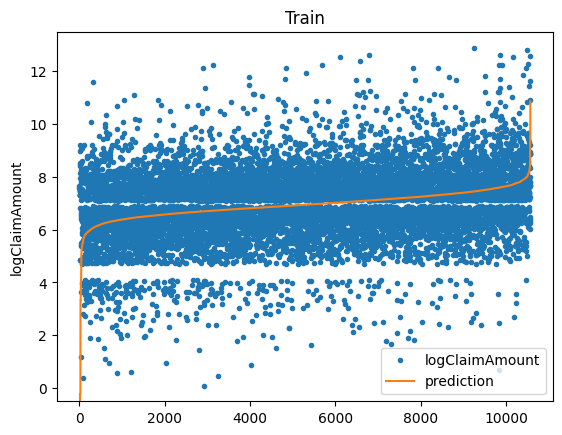

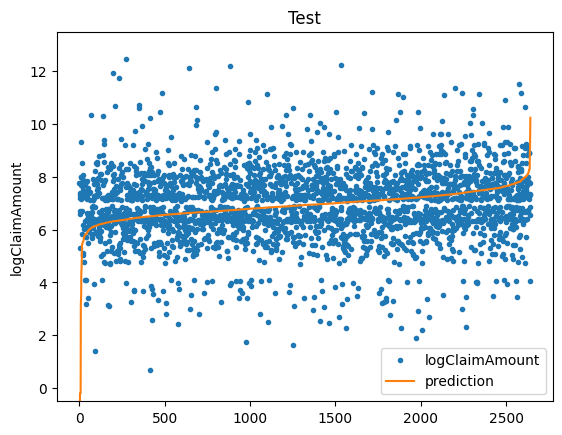

In [44]:
ylim = [-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5]
sort_by_pred = True
fig_train, ax_train = plt.subplots()
plot_fastai_regression(
    preds_train, 
    targs_train, 
    ax_train, 
    sort_by_pred=sort_by_pred, 
    ylabel='logClaimAmount', 
    ylim=ylim, 
    title='Train', 
)
fig_test, ax_test = plt.subplots()
plot_fastai_regression(
    preds_test, 
    targs_test, 
    ax_test, 
    sort_by_pred=sort_by_pred, 
    ylabel='logClaimAmount', 
    ylim=ylim, 
    title='Test', 
)        

In [45]:
def calc_rmse(preds, targs):
    return np.sqrt(((preds - targs) ** 2).mean())

In [46]:
print(
    "Training RMSE ="
    f" {calc_rmse(preds_train, targs_train).item()}"
)
print(
    "Test RMSE ="
    f" {calc_rmse(preds_test, targs_test).item()}"
)

Training RMSE = 1.5241183042526245
Test RMSE = 1.6207787990570068


Here we see that the model now has more freedom to follow the spread of values better. However, we do loose on the RMSE do to the fact that we through out the very easy piece of the data to follow. Let's see how the XGBoost performs now if we used the embeddings generated from the fast.ai model.

### Extract embeddings and insert back into feature matrix

In [47]:
embs = [param for param in learn.model.embeds.parameters()]
cat = to.procs.categorify

In [48]:
def emb2df(emb, feature, cat):
    return pd.DataFrame(
        emb, 
        index=cat, 
        columns=[
            f'{feature}_emb_{i}' for i in range(emb.shape[1])
        ]
    ).reset_index().rename({'index': feature}, axis=1)

In [49]:
X_y_emb_df = log_claim_cont_cat_nonull_df.copy()
for i_feat, feature in enumerate(list(cat.classes.keys())):
    X_y_emb_df = pd.merge(
        X_y_emb_df, 
        emb2df(embs[i_feat].detach().cpu().numpy(), feature, cat[feature]), 
        how='left', 
        on=feature, 
    ).drop(feature, axis=1)

In [50]:
X_y_emb_df

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,logClaimAmount,Area_emb_0,...,VehGas_emb_2,Region_emb_0,Region_emb_1,Region_emb_2,Region_emb_3,Region_emb_4,Region_emb_5,Region_emb_6,Region_emb_7,Region_emb_8
0,139.0,1.0,0.75,7.0,1.0,61.0,50.0,27000.0,5.713733,0.012776,...,-0.010997,0.019043,0.028518,-0.010179,0.031377,-0.038126,-0.000693,0.010191,0.008573,0.010114
1,190.0,1.0,0.14,12.0,5.0,50.0,60.0,56.0,7.591781,0.089038,...,-0.005644,0.036009,-0.003036,0.009171,0.045589,0.005467,-0.024060,0.035029,0.024779,-0.017071
2,414.0,1.0,0.14,4.0,0.0,36.0,85.0,4792.0,7.283826,0.041700,...,-0.010997,0.019043,0.028518,-0.010179,0.031377,-0.038126,-0.000693,0.010191,0.008573,0.010114
3,424.0,2.0,0.62,10.0,0.0,51.0,100.0,27000.0,6.897341,0.012776,...,-0.010997,0.019043,0.028518,-0.010179,0.031377,-0.038126,-0.000693,0.010191,0.008573,0.010114
4,424.0,2.0,0.62,10.0,0.0,51.0,100.0,27000.0,9.194654,0.012776,...,-0.010997,0.019043,0.028518,-0.010179,0.031377,-0.038126,-0.000693,0.010191,0.008573,0.010114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26439,6113793.0,1.0,0.14,7.0,2.0,51.0,50.0,178.0,7.478667,0.013919,...,-0.005644,0.049311,-0.010887,0.042977,-0.019298,0.057119,0.038566,-0.030430,-0.000415,0.058125
26440,6113817.0,1.0,0.17,4.0,0.0,35.0,51.0,1719.0,7.161063,-0.047232,...,-0.010997,-0.005599,0.009012,0.002253,-0.006921,0.040222,0.000631,0.002417,-0.043051,0.046039
26441,6113834.0,2.0,0.17,15.0,3.0,36.0,50.0,181.0,9.238928,0.013919,...,-0.010997,0.046259,-0.024196,0.059816,0.003726,-0.006085,0.014263,-0.006562,-0.007906,-0.033263
26442,6113834.0,2.0,0.17,15.0,3.0,36.0,50.0,181.0,7.570649,0.013919,...,-0.010997,0.046259,-0.024196,0.059816,0.003726,-0.006085,0.014263,-0.006562,-0.007906,-0.033263


## XGBoost with embedded categorical features
This time, we'll also fit without the strong bands because I believe that this is the path to providing a more fair prediction. At least the the models tried so far.

### Prepare fitting inputs

In [51]:
# Make middle thresholds equal to erase their effect
REMOVE_BANDS = 1
log_claim_low_thresh = 0
log_claim_med1_thresh = 4.1 if REMOVE_BANDS else 4.4
log_claim_med2_thresh = 4.7 if REMOVE_BANDS else 4.4
log_claim_med3_thresh = 6.9 if REMOVE_BANDS else 7
log_claim_med4_thresh = 7.1 if REMOVE_BANDS else 7
log_claim_high_thresh = 13

In [52]:
sample_select = (
    (
        (
            X_y_emb_df['logClaimAmount'] 
            > log_claim_low_thresh
        )
        & (
            X_y_emb_df['logClaimAmount'] 
            <= log_claim_med1_thresh
        )
    ) 
    | (
        (
            X_y_emb_df['logClaimAmount'] 
            > log_claim_med2_thresh
        )
        & (
            X_y_emb_df['logClaimAmount'] 
            <= log_claim_med3_thresh
        )
    )
    | (
        (
            X_y_emb_df['logClaimAmount'] 
            > log_claim_med4_thresh
        )
        & (
            X_y_emb_df['logClaimAmount'] 
            <= log_claim_high_thresh
        )
    )
)

In [53]:
scaler = MinMaxScaler()
features_nonull_df = (
    X_y_emb_df
        .loc[sample_select, :]
        .set_index('IDpol')
        .drop('logClaimAmount', axis=1)
)
features_nonull = scaler.fit_transform(features_nonull_df)
features_nonull_df = pd.DataFrame(
    features_nonull, 
    columns=features_nonull_df.columns, 
    index=features_nonull_df.index, 
)
features_nonull_df

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_emb_0,Area_emb_1,Area_emb_2,...,VehGas_emb_2,Region_emb_0,Region_emb_1,Region_emb_2,Region_emb_3,Region_emb_4,Region_emb_5,Region_emb_6,Region_emb_7,Region_emb_8
IDpol,,,,,,,,,,,,,,,,,,,,,
139.0,0.000000,0.388886,0.272727,0.011905,0.530864,0.000000,1.000000,0.440358,1.000000,0.288064,...,0.0,0.773363,0.599264,0.411808,0.631973,0.330307,0.520950,0.594609,0.579267,0.717059
190.0,0.000000,0.070271,0.727273,0.059524,0.395062,0.068493,0.002000,1.000000,0.000000,1.000000,...,1.0,0.900400,0.384517,0.556320,0.747003,0.636816,0.365792,0.734871,0.724768,0.556856
414.0,0.000000,0.070271,0.000000,0.000000,0.222222,0.239726,0.177421,0.652614,0.938798,0.009447,...,0.0,0.773363,0.599264,0.411808,0.631973,0.330307,0.520950,0.594609,0.579267,0.717059
424.0,0.066667,0.320984,0.545455,0.000000,0.407407,0.342466,1.000000,0.440358,1.000000,0.288064,...,0.0,0.773363,0.599264,0.411808,0.631973,0.330307,0.520950,0.594609,0.579267,0.717059
424.0,0.066667,0.320984,0.545455,0.000000,0.407407,0.342466,1.000000,0.440358,1.000000,0.288064,...,0.0,0.773363,0.599264,0.411808,0.631973,0.330307,0.520950,0.594609,0.579267,0.717059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6113793.0,0.000000,0.070271,0.272727,0.023810,0.407407,0.000000,0.006519,0.448744,0.889118,0.000000,...,1.0,1.000000,0.331082,0.808802,0.221805,1.000000,0.781637,0.365207,0.498568,1.000000
6113817.0,0.000000,0.085940,0.000000,0.000000,0.209877,0.006849,0.063597,0.000000,0.199659,0.198914,...,0.0,0.588852,0.466510,0.504656,0.321981,0.881189,0.529746,0.550701,0.115775,0.928775
6113834.0,0.066667,0.085940,1.000000,0.035714,0.222222,0.000000,0.006630,0.448744,0.889118,0.000000,...,0.0,0.977147,0.240504,0.934561,0.408164,0.555593,0.620265,0.499996,0.431315,0.461432


In [54]:
log_claim_amount_nonull_df = (
    X_y_emb_df[['IDpol', 'logClaimAmount']]
        .loc[sample_select, :]
        .set_index('IDpol')
)
log_claim_amount_nonull_df

,logClaimAmount
IDpol,
139.0,5.713733
190.0,7.591781
414.0,7.283826
424.0,6.897341
424.0,9.194654
...,...
6113793.0,7.478667
6113817.0,7.161063
6113834.0,9.238928


### Setup model

In [55]:
X_df = features_nonull_df
y_df = log_claim_amount_nonull_df

In [56]:
objective = 'reg:absoluteerror'
eval_metric = 'rmse'
enable_categorical = False

In [57]:
model = XGBRegressor(
    n_estimators=100, 
    eta=0.3, # 0.3
    gamma=1, # 0
    max_depth=6, # 6
    max_leaves=10, 
    min_child_weight=20, # 1
    subsample=0.5, # 1
    reg_lambda=10, # 1 (L2)
    reg_alpha=2, # 0 (L1)
    grow_policy='depthwise', # depthwise
    tree_method='hist', # auto
    max_bin=16, # 256
    random_state=0, 
    enable_categorical=enable_categorical, 
    objective=objective, 
    eval_metric=eval_metric, 
)

### Cross-validation

In [58]:
cv_iterator = KFold(
    n_splits=10, 
    shuffle=True, 
    random_state=0, 
)

In [59]:
cv_results = cross_validate(
    model, 
    X_df, 
    y_df, 
    scoring=[
        'neg_root_mean_squared_error', 
        'neg_median_absolute_error', 
    ], 
    cv=cv_iterator, 
    return_estimator=True, 
)

In [60]:
print(
    "Average test_neg_root_mean_squared_error"
    f" = {cv_results['test_neg_root_mean_squared_error'].mean()}"
)
print(
    "Average test_neg_median_absolute_error"
    f" = {cv_results['test_neg_median_absolute_error'].mean()}"
)

Average test_neg_root_mean_squared_error = -1.3232566644152703
Average test_neg_median_absolute_error = -0.7764088348131508


### Plot results

In [61]:
def plot_regression(
        X_df, 
        y_df, 
        fold, 
        i_data, 
        cv_results,
        ax,  
        sort_by_pred=True, 
        col=None, 
        **kwargs, 
    ):
    X_data_df = X_df.iloc[i_data]
    y_pred_df = pd.DataFrame(
        cv_results['estimator'][fold]
            .predict(X_data_df)
            .flatten(), 
        columns=['prediction'], 
        index=X_data_df.index
    )
    y_data_df = y_df.iloc[i_data]
    y_fold_df = pd.concat([y_data_df, y_pred_df], axis=1)
    X_y_fold_df = pd.concat([X_data_df, y_fold_df], axis=1)
    sort_col = 'prediction' if sort_by_pred else 'logClaimAmount'
    if col is None:
        y_fold_df = y_fold_df.sort_values(sort_col)
        ax.plot(
            y_fold_df['logClaimAmount'].to_numpy(), 
            marker='.',
            linestyle='', 
            label='logClaimAmount', 
        )
        ax.plot(y_fold_df['prediction'].to_numpy(), label='prediction')
    else:
        X_y_fold_df = X_y_fold_df.sort_values(col)
        ax.plot(
            X_y_fold_df[col].to_numpy(), 
            X_y_fold_df['logClaimAmount'].to_numpy(), 
            marker='.',
            linestyle='', 
            label='logClaimAmount', 
        )
        ax.plot(
            X_y_fold_df[col].to_numpy(), 
            X_y_fold_df['prediction'].to_numpy(), 
            label='prediction'
        )
        ax.set_xlabel(col)
    ax.legend()
    _ = ax.set(**kwargs)

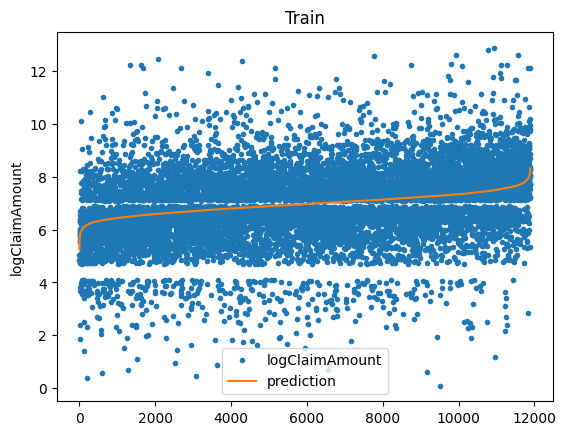

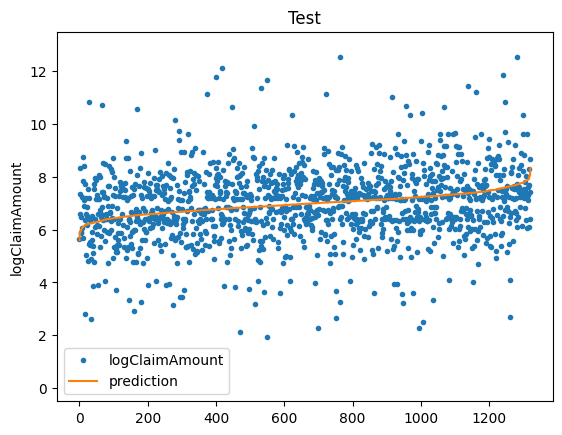

In [62]:
fold = 0
ylim = [-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5]
sort_by_pred = True
for fold_i, (train_i, test_i) in enumerate(
    cv_iterator.split(X_df, y_df)
):
    if fold_i==fold:
        fig_train, ax_train = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            train_i, 
            cv_results, 
            ax_train, 
            sort_by_pred=sort_by_pred, 
            ylabel='logClaimAmount', 
            ylim=ylim, 
            title='Train', 
        )
        fig_test, ax_test = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            test_i, 
            cv_results, 
            ax_test, 
            sort_by_pred=sort_by_pred, 
            ylabel='logClaimAmount', 
            ylim=ylim, 
            title='Test', 
        )        

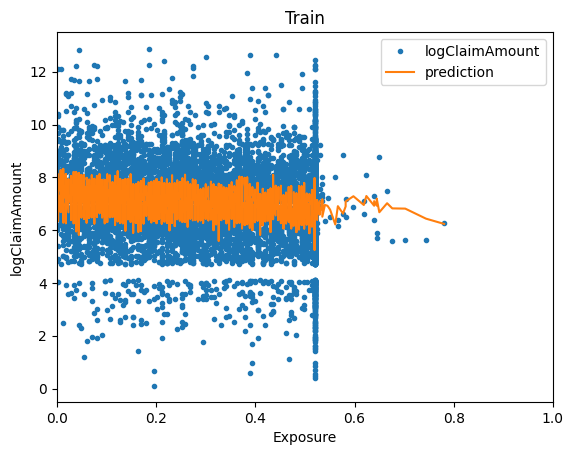

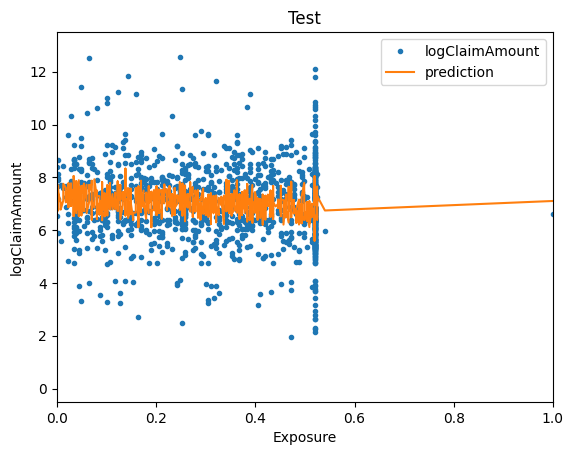

In [63]:
fold = 0
ylim = [-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5]
xlim = [0, 1]
sort_by_pred = True
col = "Exposure"
for fold_i, (train_i, test_i) in enumerate(
    cv_iterator.split(X_df, y_df)
):
    if fold_i==fold:
        fig_train, ax_train = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            train_i, 
            cv_results, 
            ax_train, 
            sort_by_pred=sort_by_pred, 
            col=col, 
            ylabel='logClaimAmount', 
            ylim=ylim, 
            xlim=xlim, 
            title='Train', 
        )
        fig_test, ax_test = plt.subplots()
        plot_regression(
            X_df, 
            y_df, 
            fold_i, 
            test_i, 
            cv_results, 
            ax_test, 
            sort_by_pred=sort_by_pred, 
            col=col, 
            ylabel='logClaimAmount', 
            xlim=xlim, 
            ylim=ylim, 
            title='Test', 
        )        

/var/folders/tg/21p0d_7d09jbj1bhx78hmwph0000gp/T/ipykernel_96446/632942894.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_test, ax_test = plt.subplots()


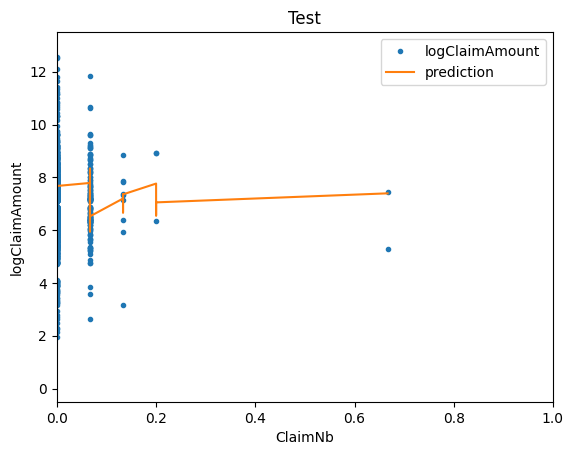

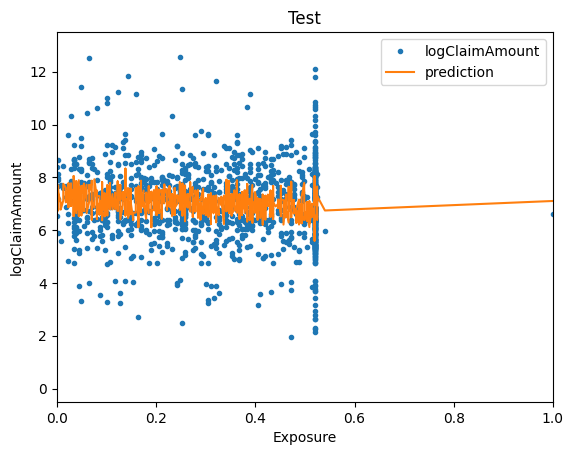

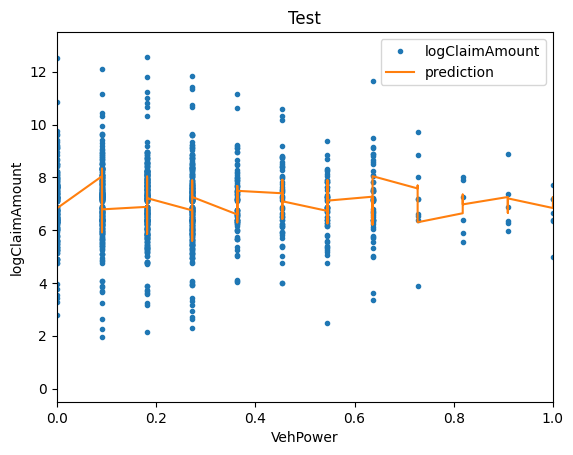

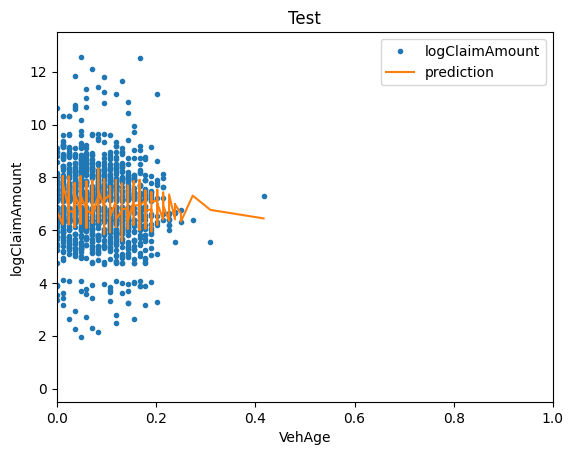

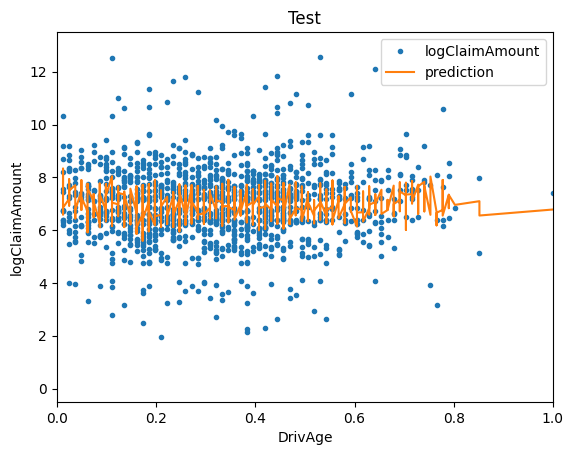

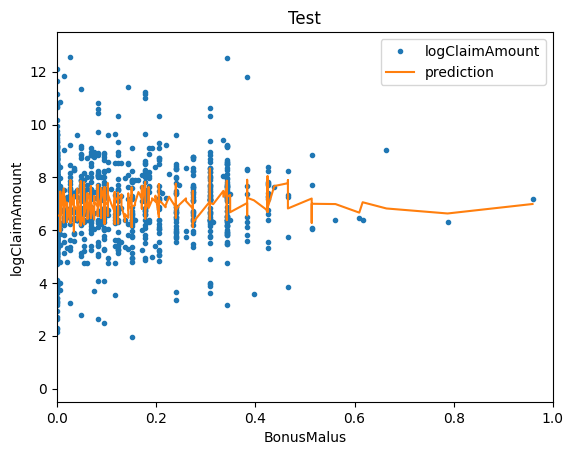

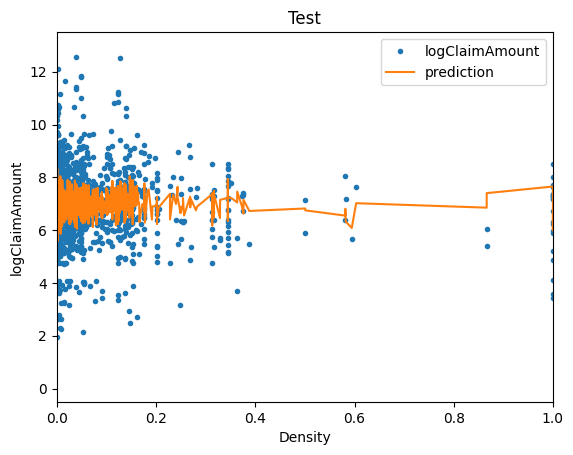

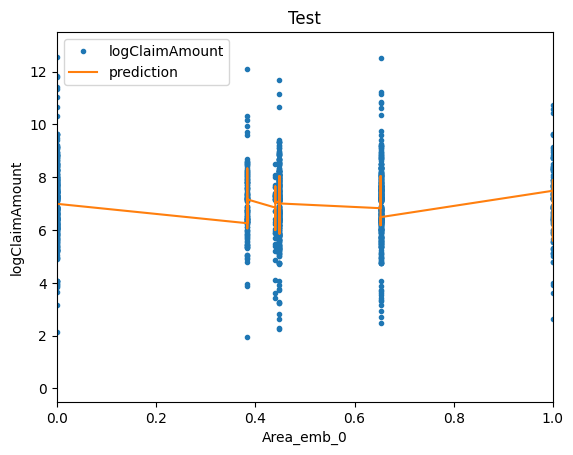

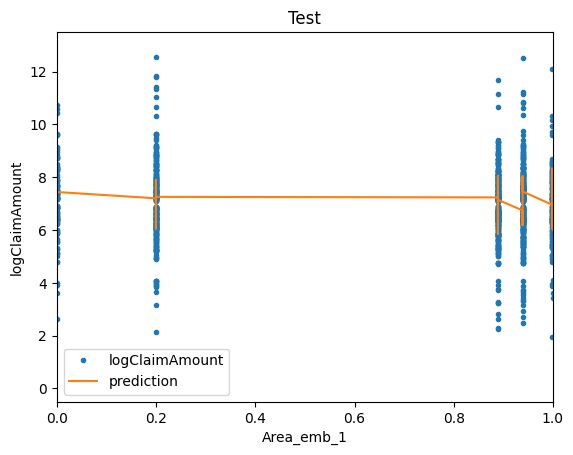

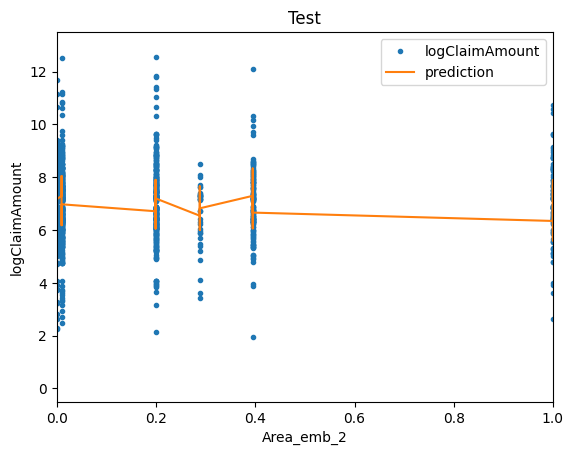

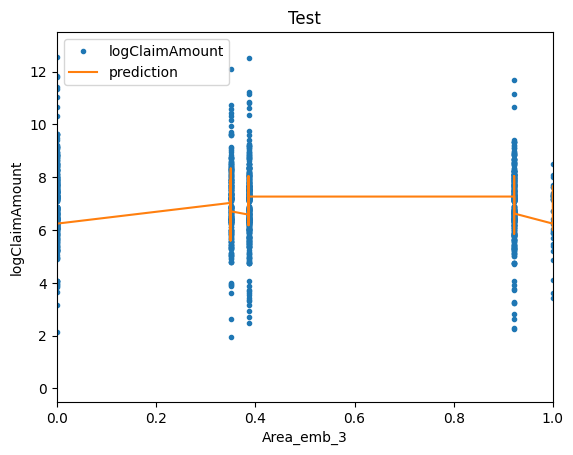

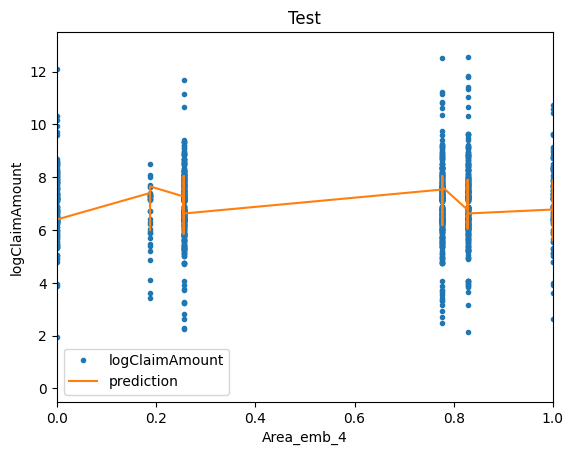

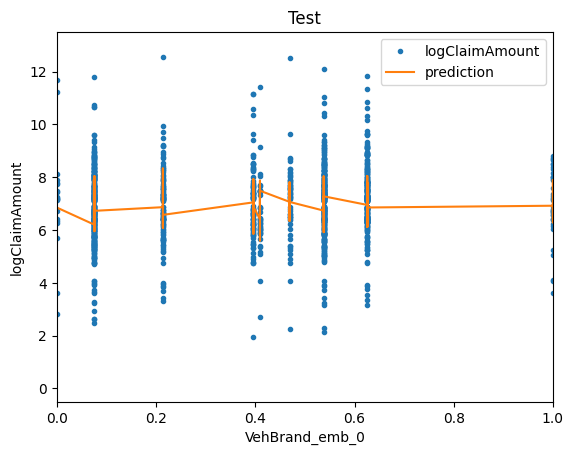

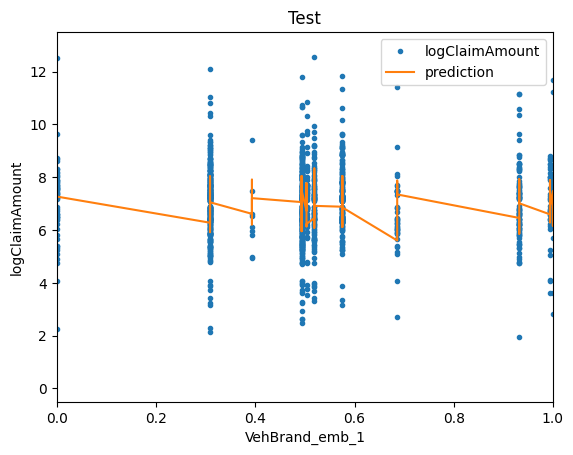

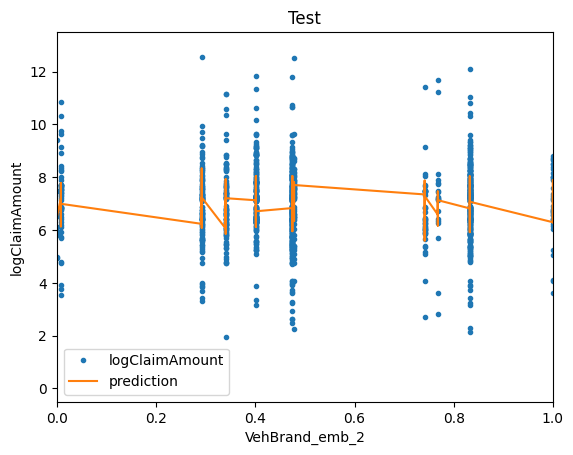

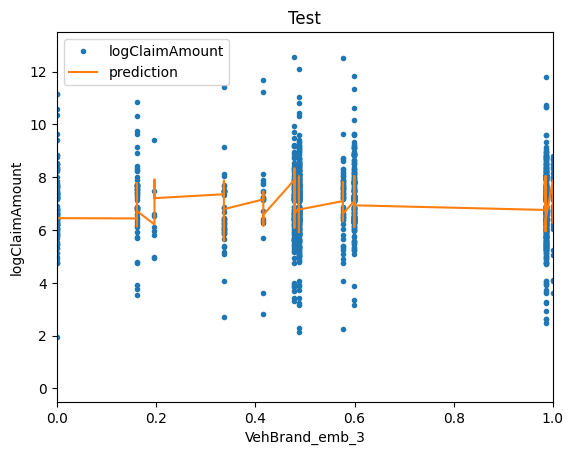

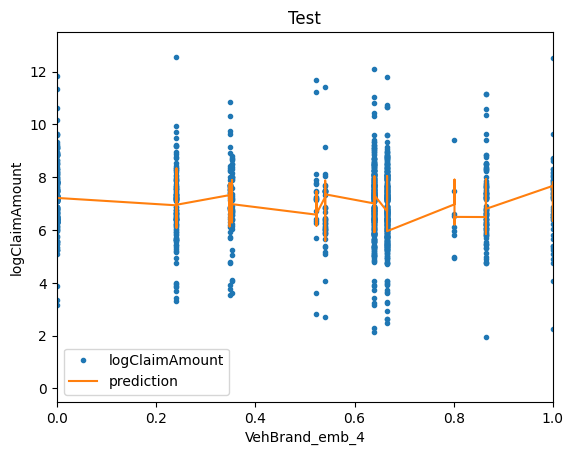

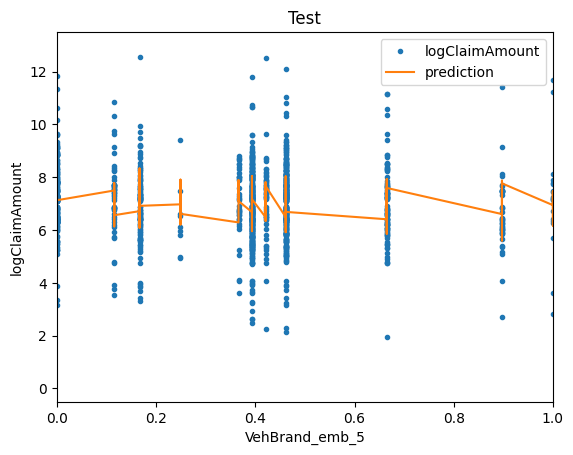

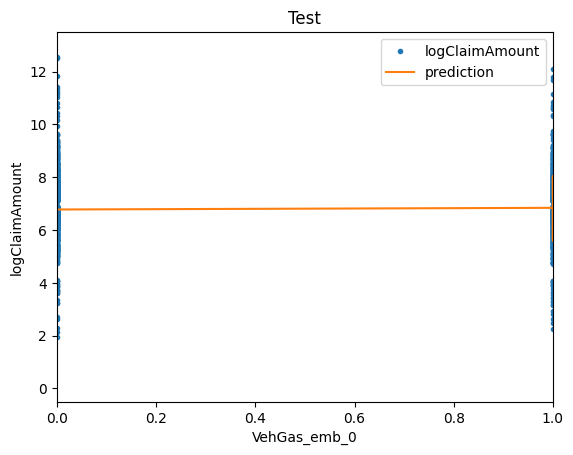

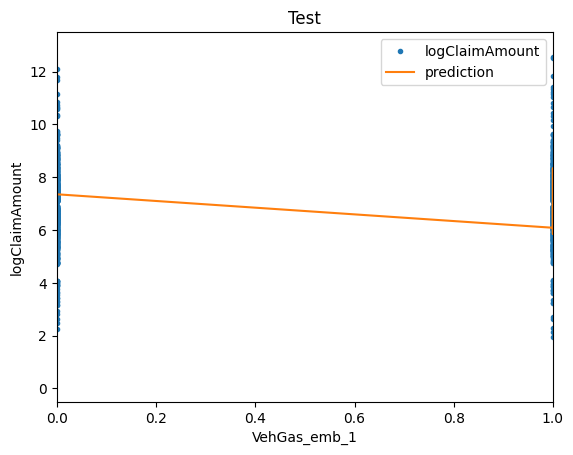

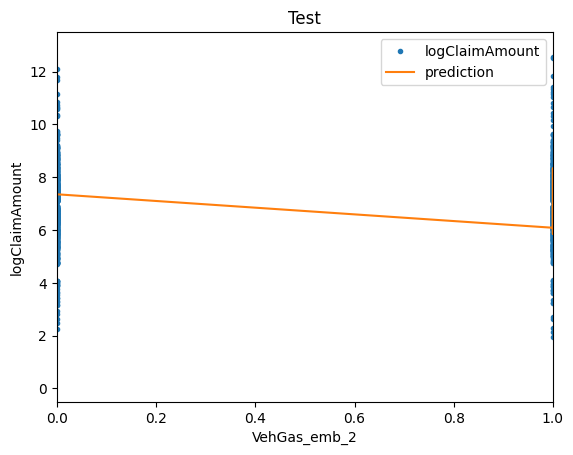

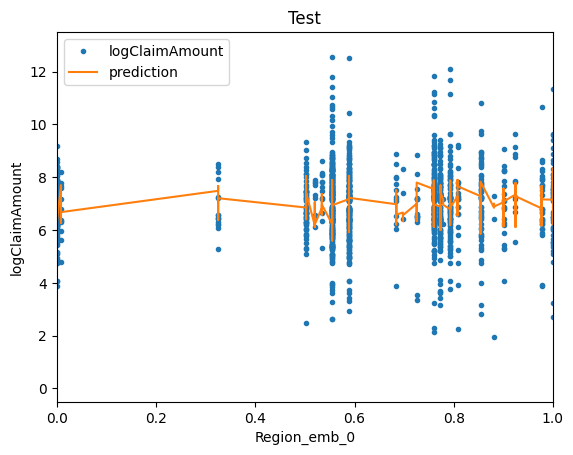

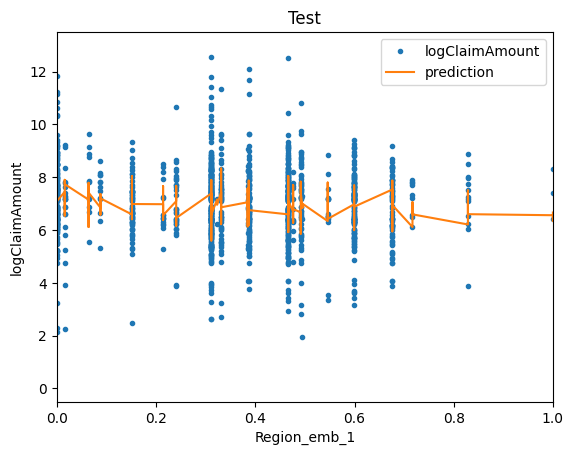

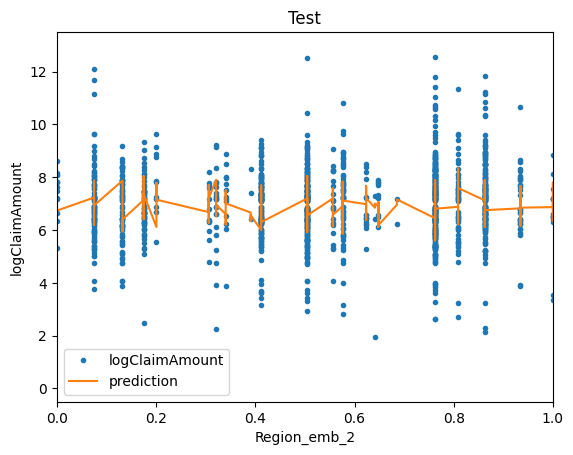

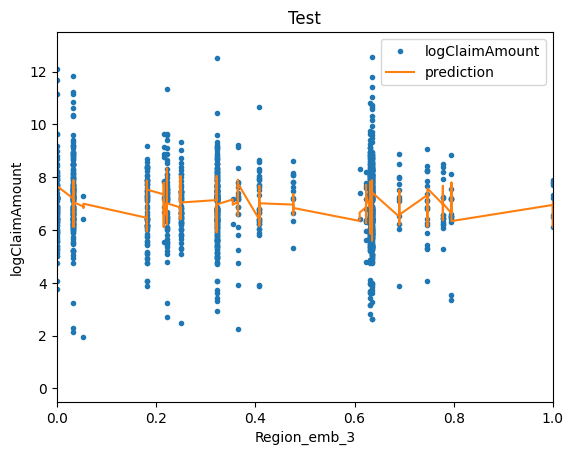

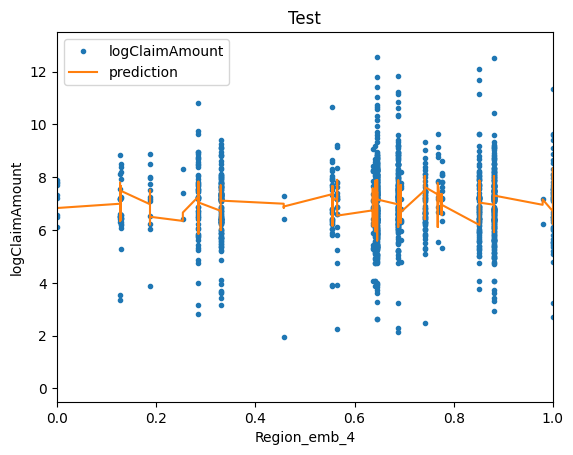

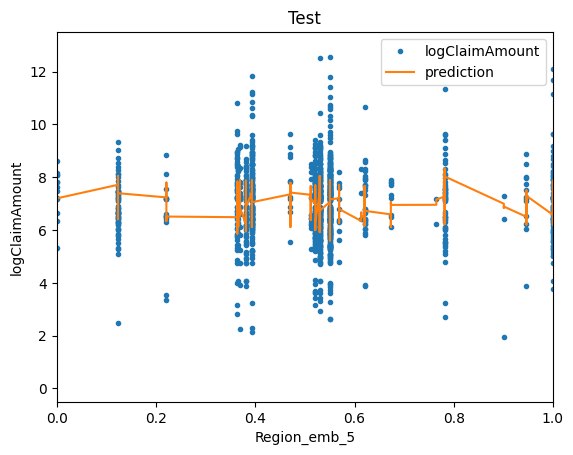

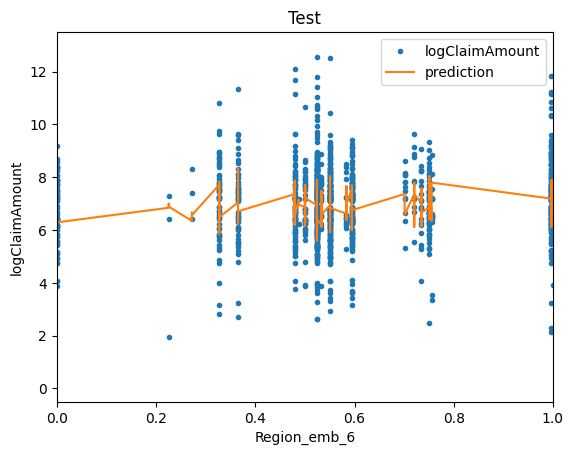

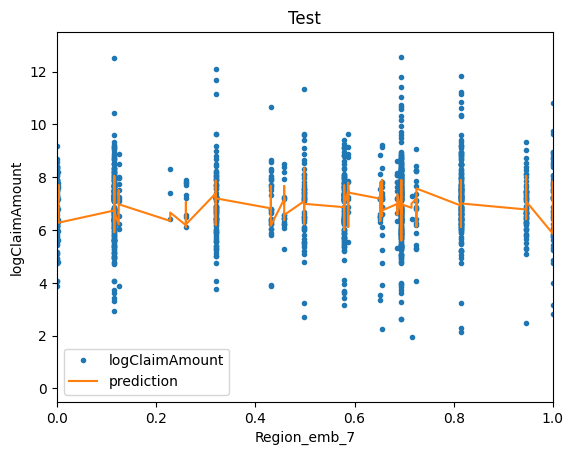

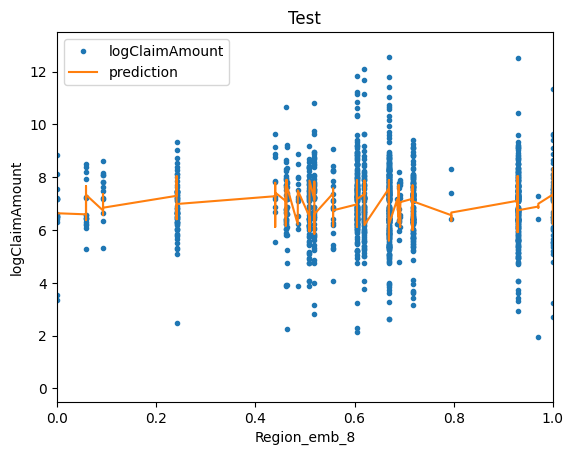

In [64]:
# Plot dependencies over all variables one-by-one
if 1:
    fold = 0
    ylim = [-.5 + log_claim_low_thresh, log_claim_high_thresh + 0.5]
    xlim = [0, 1]
    sort_by_pred = True
    for col in X_df.columns:
        for fold_i, (train_i, test_i) in enumerate(
            cv_iterator.split(X_df, y_df)
        ):
            if fold_i==fold:
                fig_test, ax_test = plt.subplots()
                plot_regression(
                    X_df, 
                    y_df, 
                    fold_i, 
                    test_i, 
                    cv_results, 
                    ax_test, 
                    sort_by_pred=sort_by_pred, 
                    col=col, 
                    ylabel='logClaimAmount', 
                    xlim=xlim, 
                    ylim=ylim, 
                    title='Test', 
                )        

I'm going to have to go with this for now. Unfortunately I didn't remember that I should be turning this into a model for pricing per year. I'm going to submit now and work on that part if I'm allowed before our meeting tomorrow.

Hope you had fun walking through this! It was a fun exercise!

jon

# End